# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

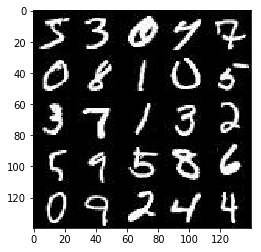

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

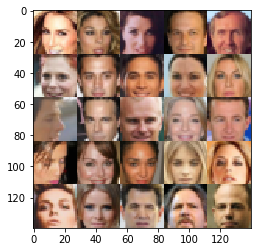

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [39]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels))
    input_Z=tf.placeholder(tf.float32,(None,z_dim))
    learning_rate=tf.placeholder(tf.float32)

    return input_real, input_Z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [40]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        
        # Input layer is 28x28x3
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1=tf.maximum(0.2*x1,x1)
        #14x14x64
        
        x2=tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2=tf.layers.batch_normalization(x2,training=True)
        relu2=tf.maximum(0.2*bn2,bn2)
        #7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse=False if is_train else True
    with tf.variable_scope('generator',reuse=reuse ):
        x1 = tf.layers.dense(z, 7*7*128)
    
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x128
    
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3    
        
        out = 0.5*tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [82]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [86]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every=100
    print_every=10
    steps=0
    out_channel_dim=data_shape[3]
    
    input_real, input_z,learningrate=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    dloss,gloss= model_loss(input_real, input_z, out_channel_dim)
        
    d_opt, g_opt = model_opt(dloss, gloss, learningrate, beta1)
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _=sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningrate: learning_rate})
                _=sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningrate: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = dloss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gloss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(steps, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                
                if steps % show_every == 0:
                    inputz=tf.identity(input_z)
                    sess.run(inputz,feed_dict={input_z: batch_z})
                    
                    show_generator_output(sess, 36, inputz, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 10/2... Discriminator Loss: 1.0393... Generator Loss: 0.5906
Epoch 20/2... Discriminator Loss: 0.7908... Generator Loss: 0.8730
Epoch 30/2... Discriminator Loss: 0.7855... Generator Loss: 0.9614
Epoch 40/2... Discriminator Loss: 0.9216... Generator Loss: 0.7752
Epoch 50/2... Discriminator Loss: 0.7093... Generator Loss: 1.3295
Epoch 60/2... Discriminator Loss: 0.7923... Generator Loss: 0.8390
Epoch 70/2... Discriminator Loss: 0.6892... Generator Loss: 0.9643
Epoch 80/2... Discriminator Loss: 0.7056... Generator Loss: 1.0099
Epoch 90/2... Discriminator Loss: 0.7354... Generator Loss: 1.3024
Epoch 100/2... Discriminator Loss: 0.8123... Generator Loss: 1.5983


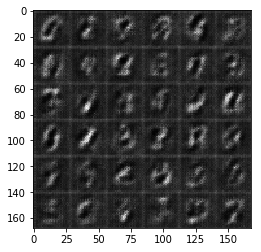

Epoch 110/2... Discriminator Loss: 0.9161... Generator Loss: 1.4343
Epoch 120/2... Discriminator Loss: 0.9973... Generator Loss: 1.4047
Epoch 130/2... Discriminator Loss: 1.0407... Generator Loss: 1.3187
Epoch 140/2... Discriminator Loss: 1.0396... Generator Loss: 0.6756
Epoch 150/2... Discriminator Loss: 1.0252... Generator Loss: 1.3485
Epoch 160/2... Discriminator Loss: 1.1790... Generator Loss: 1.4827
Epoch 170/2... Discriminator Loss: 0.9302... Generator Loss: 0.9459
Epoch 180/2... Discriminator Loss: 1.0582... Generator Loss: 0.6385
Epoch 190/2... Discriminator Loss: 1.0052... Generator Loss: 0.6994
Epoch 200/2... Discriminator Loss: 0.9474... Generator Loss: 1.0143


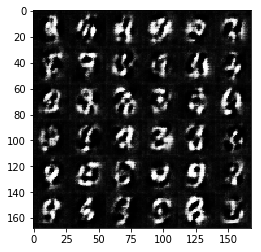

Epoch 210/2... Discriminator Loss: 1.2555... Generator Loss: 1.6432
Epoch 220/2... Discriminator Loss: 1.1991... Generator Loss: 0.5690
Epoch 230/2... Discriminator Loss: 1.1019... Generator Loss: 0.6610
Epoch 240/2... Discriminator Loss: 0.9480... Generator Loss: 0.8812
Epoch 250/2... Discriminator Loss: 1.0120... Generator Loss: 1.1787
Epoch 260/2... Discriminator Loss: 1.1103... Generator Loss: 1.1293
Epoch 270/2... Discriminator Loss: 0.9264... Generator Loss: 1.1123
Epoch 280/2... Discriminator Loss: 1.1758... Generator Loss: 0.5729
Epoch 290/2... Discriminator Loss: 0.9978... Generator Loss: 1.1661
Epoch 300/2... Discriminator Loss: 1.0589... Generator Loss: 0.7911


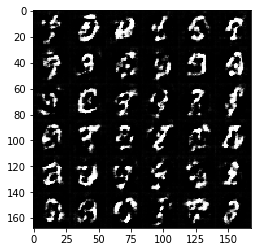

Epoch 310/2... Discriminator Loss: 0.9133... Generator Loss: 0.9640
Epoch 320/2... Discriminator Loss: 0.9238... Generator Loss: 1.3888
Epoch 330/2... Discriminator Loss: 0.9852... Generator Loss: 0.9341
Epoch 340/2... Discriminator Loss: 0.9487... Generator Loss: 1.1370
Epoch 350/2... Discriminator Loss: 0.9464... Generator Loss: 0.9129
Epoch 360/2... Discriminator Loss: 0.9201... Generator Loss: 1.0007
Epoch 370/2... Discriminator Loss: 1.0131... Generator Loss: 1.7695
Epoch 380/2... Discriminator Loss: 0.8761... Generator Loss: 0.9686
Epoch 390/2... Discriminator Loss: 1.2114... Generator Loss: 0.5385
Epoch 400/2... Discriminator Loss: 0.9260... Generator Loss: 1.4146


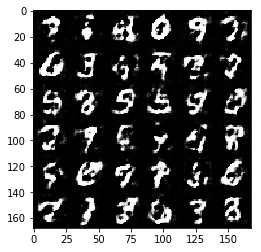

Epoch 410/2... Discriminator Loss: 0.8916... Generator Loss: 1.2744
Epoch 420/2... Discriminator Loss: 0.9058... Generator Loss: 0.7698
Epoch 430/2... Discriminator Loss: 0.8863... Generator Loss: 1.8895
Epoch 440/2... Discriminator Loss: 0.8036... Generator Loss: 1.0391
Epoch 450/2... Discriminator Loss: 0.8672... Generator Loss: 1.4386
Epoch 460/2... Discriminator Loss: 0.9535... Generator Loss: 1.0739
Epoch 470/2... Discriminator Loss: 0.8315... Generator Loss: 1.3142
Epoch 480/2... Discriminator Loss: 0.8097... Generator Loss: 1.2917
Epoch 490/2... Discriminator Loss: 0.8352... Generator Loss: 1.2976
Epoch 500/2... Discriminator Loss: 0.8368... Generator Loss: 1.0319


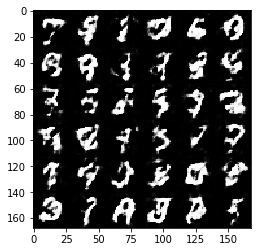

Epoch 510/2... Discriminator Loss: 0.6681... Generator Loss: 1.3848
Epoch 520/2... Discriminator Loss: 1.0124... Generator Loss: 0.6476
Epoch 530/2... Discriminator Loss: 0.7868... Generator Loss: 1.1067
Epoch 540/2... Discriminator Loss: 0.8532... Generator Loss: 0.8603
Epoch 550/2... Discriminator Loss: 1.0216... Generator Loss: 1.9690
Epoch 560/2... Discriminator Loss: 0.7604... Generator Loss: 1.3546
Epoch 570/2... Discriminator Loss: 0.7379... Generator Loss: 1.2738
Epoch 580/2... Discriminator Loss: 0.8713... Generator Loss: 1.5947
Epoch 590/2... Discriminator Loss: 0.9473... Generator Loss: 0.9010
Epoch 600/2... Discriminator Loss: 0.7559... Generator Loss: 1.3348


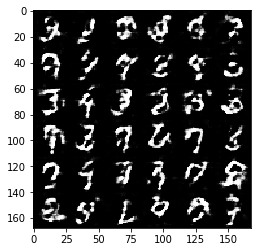

Epoch 610/2... Discriminator Loss: 0.7800... Generator Loss: 1.0698
Epoch 620/2... Discriminator Loss: 0.6377... Generator Loss: 1.2734
Epoch 630/2... Discriminator Loss: 0.9450... Generator Loss: 0.9139
Epoch 640/2... Discriminator Loss: 0.8305... Generator Loss: 0.9561
Epoch 650/2... Discriminator Loss: 0.8451... Generator Loss: 0.9550
Epoch 660/2... Discriminator Loss: 0.8248... Generator Loss: 1.0570
Epoch 670/2... Discriminator Loss: 0.7228... Generator Loss: 1.5237
Epoch 680/2... Discriminator Loss: 0.8671... Generator Loss: 0.8917
Epoch 690/2... Discriminator Loss: 0.7564... Generator Loss: 1.1938
Epoch 700/2... Discriminator Loss: 0.9845... Generator Loss: 1.0061


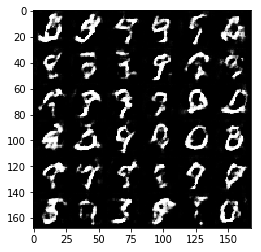

Epoch 710/2... Discriminator Loss: 0.8456... Generator Loss: 0.9744
Epoch 720/2... Discriminator Loss: 0.7550... Generator Loss: 1.3859
Epoch 730/2... Discriminator Loss: 0.8427... Generator Loss: 1.0623
Epoch 740/2... Discriminator Loss: 0.7950... Generator Loss: 1.3339
Epoch 750/2... Discriminator Loss: 0.7943... Generator Loss: 1.1198
Epoch 760/2... Discriminator Loss: 0.8068... Generator Loss: 1.1994
Epoch 770/2... Discriminator Loss: 0.7605... Generator Loss: 1.5847
Epoch 780/2... Discriminator Loss: 0.9939... Generator Loss: 0.7087
Epoch 790/2... Discriminator Loss: 0.8891... Generator Loss: 0.8711
Epoch 800/2... Discriminator Loss: 1.2182... Generator Loss: 1.9922


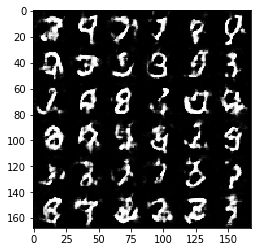

Epoch 810/2... Discriminator Loss: 0.9041... Generator Loss: 0.9409
Epoch 820/2... Discriminator Loss: 0.8991... Generator Loss: 1.5843
Epoch 830/2... Discriminator Loss: 0.8545... Generator Loss: 1.1960
Epoch 840/2... Discriminator Loss: 0.9270... Generator Loss: 1.2342
Epoch 850/2... Discriminator Loss: 0.9853... Generator Loss: 0.8275
Epoch 860/2... Discriminator Loss: 1.1269... Generator Loss: 0.6898
Epoch 870/2... Discriminator Loss: 1.2048... Generator Loss: 1.7155
Epoch 880/2... Discriminator Loss: 0.9737... Generator Loss: 1.2525
Epoch 890/2... Discriminator Loss: 0.9980... Generator Loss: 0.8880
Epoch 900/2... Discriminator Loss: 1.0474... Generator Loss: 1.3650


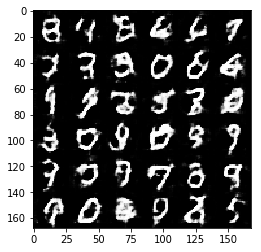

Epoch 910/2... Discriminator Loss: 1.2564... Generator Loss: 0.6265
Epoch 920/2... Discriminator Loss: 0.9403... Generator Loss: 1.2419
Epoch 930/2... Discriminator Loss: 0.8369... Generator Loss: 1.4014


In [87]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 10/1... Discriminator Loss: 0.9111... Generator Loss: 0.7563
Epoch 20/1... Discriminator Loss: 0.5666... Generator Loss: 1.2068
Epoch 30/1... Discriminator Loss: 0.5240... Generator Loss: 1.4555
Epoch 40/1... Discriminator Loss: 0.4874... Generator Loss: 1.5521
Epoch 50/1... Discriminator Loss: 0.4578... Generator Loss: 1.6413
Epoch 60/1... Discriminator Loss: 0.4821... Generator Loss: 1.8439
Epoch 70/1... Discriminator Loss: 0.9190... Generator Loss: 0.6968
Epoch 80/1... Discriminator Loss: 0.8788... Generator Loss: 1.7034
Epoch 90/1... Discriminator Loss: 0.9043... Generator Loss: 1.3776
Epoch 100/1... Discriminator Loss: 0.8463... Generator Loss: 1.4635


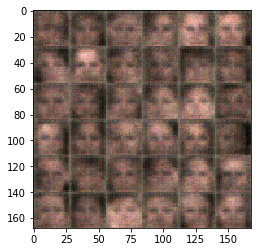

Epoch 110/1... Discriminator Loss: 0.9010... Generator Loss: 0.9038
Epoch 120/1... Discriminator Loss: 0.8082... Generator Loss: 1.1821
Epoch 130/1... Discriminator Loss: 0.9844... Generator Loss: 0.7650
Epoch 140/1... Discriminator Loss: 1.1089... Generator Loss: 1.7289
Epoch 150/1... Discriminator Loss: 0.9417... Generator Loss: 0.8560
Epoch 160/1... Discriminator Loss: 0.9655... Generator Loss: 1.4892
Epoch 170/1... Discriminator Loss: 0.8569... Generator Loss: 1.5921
Epoch 180/1... Discriminator Loss: 0.9783... Generator Loss: 0.8015
Epoch 190/1... Discriminator Loss: 0.9987... Generator Loss: 1.0438
Epoch 200/1... Discriminator Loss: 1.0827... Generator Loss: 0.8879


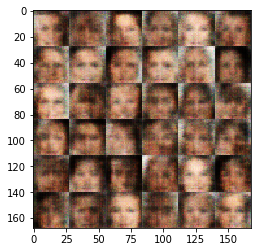

Epoch 210/1... Discriminator Loss: 1.0705... Generator Loss: 0.9680
Epoch 220/1... Discriminator Loss: 1.1860... Generator Loss: 0.8514
Epoch 230/1... Discriminator Loss: 1.1164... Generator Loss: 1.0517
Epoch 240/1... Discriminator Loss: 1.2474... Generator Loss: 0.8042
Epoch 250/1... Discriminator Loss: 1.2490... Generator Loss: 0.9589
Epoch 260/1... Discriminator Loss: 1.2304... Generator Loss: 0.6950
Epoch 270/1... Discriminator Loss: 1.1797... Generator Loss: 1.1576
Epoch 280/1... Discriminator Loss: 1.1446... Generator Loss: 0.9002
Epoch 290/1... Discriminator Loss: 1.1368... Generator Loss: 0.9762
Epoch 300/1... Discriminator Loss: 1.0530... Generator Loss: 1.0379


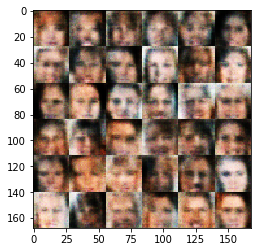

Epoch 310/1... Discriminator Loss: 1.1255... Generator Loss: 0.8396
Epoch 320/1... Discriminator Loss: 1.1519... Generator Loss: 0.6647
Epoch 330/1... Discriminator Loss: 1.0820... Generator Loss: 0.9776
Epoch 340/1... Discriminator Loss: 1.0055... Generator Loss: 1.2149
Epoch 350/1... Discriminator Loss: 1.0832... Generator Loss: 0.7733
Epoch 360/1... Discriminator Loss: 1.0755... Generator Loss: 1.0905
Epoch 370/1... Discriminator Loss: 1.0343... Generator Loss: 0.8438
Epoch 380/1... Discriminator Loss: 1.1555... Generator Loss: 0.7212
Epoch 390/1... Discriminator Loss: 1.2205... Generator Loss: 1.2490
Epoch 400/1... Discriminator Loss: 1.0887... Generator Loss: 1.2546


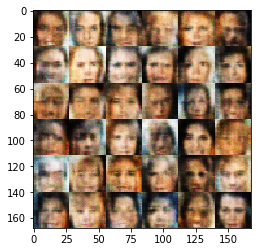

Epoch 410/1... Discriminator Loss: 0.8982... Generator Loss: 1.1112
Epoch 420/1... Discriminator Loss: 1.0386... Generator Loss: 0.7503
Epoch 430/1... Discriminator Loss: 1.1502... Generator Loss: 1.0086
Epoch 440/1... Discriminator Loss: 1.2749... Generator Loss: 0.5587
Epoch 450/1... Discriminator Loss: 1.2321... Generator Loss: 0.6315
Epoch 460/1... Discriminator Loss: 1.0580... Generator Loss: 0.8860
Epoch 470/1... Discriminator Loss: 0.9883... Generator Loss: 0.8953
Epoch 480/1... Discriminator Loss: 0.9685... Generator Loss: 0.7782
Epoch 490/1... Discriminator Loss: 0.9701... Generator Loss: 1.2067
Epoch 500/1... Discriminator Loss: 0.9317... Generator Loss: 0.9320


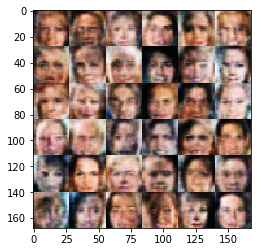

Epoch 510/1... Discriminator Loss: 0.9700... Generator Loss: 0.8940
Epoch 520/1... Discriminator Loss: 0.9360... Generator Loss: 1.2439
Epoch 530/1... Discriminator Loss: 0.9492... Generator Loss: 0.8919
Epoch 540/1... Discriminator Loss: 0.9752... Generator Loss: 1.0965
Epoch 550/1... Discriminator Loss: 0.8051... Generator Loss: 1.1256
Epoch 560/1... Discriminator Loss: 0.9423... Generator Loss: 0.9563
Epoch 570/1... Discriminator Loss: 0.9075... Generator Loss: 1.0760
Epoch 580/1... Discriminator Loss: 0.9607... Generator Loss: 1.0318
Epoch 590/1... Discriminator Loss: 0.9088... Generator Loss: 1.0802
Epoch 600/1... Discriminator Loss: 0.9918... Generator Loss: 1.0774


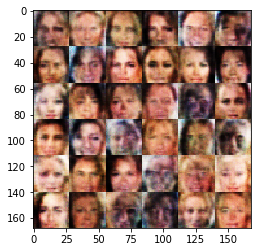

Epoch 610/1... Discriminator Loss: 1.5100... Generator Loss: 0.7969
Epoch 620/1... Discriminator Loss: 1.0433... Generator Loss: 1.0588
Epoch 630/1... Discriminator Loss: 0.9981... Generator Loss: 0.8939
Epoch 640/1... Discriminator Loss: 1.0717... Generator Loss: 0.8851
Epoch 650/1... Discriminator Loss: 1.1172... Generator Loss: 0.8622
Epoch 660/1... Discriminator Loss: 1.0569... Generator Loss: 1.2318
Epoch 670/1... Discriminator Loss: 1.1268... Generator Loss: 0.8687
Epoch 680/1... Discriminator Loss: 1.1198... Generator Loss: 1.0352
Epoch 690/1... Discriminator Loss: 1.1579... Generator Loss: 0.8442
Epoch 700/1... Discriminator Loss: 1.1686... Generator Loss: 0.8768


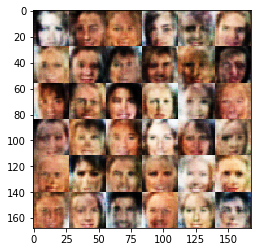

Epoch 710/1... Discriminator Loss: 1.0290... Generator Loss: 1.0760
Epoch 720/1... Discriminator Loss: 1.3915... Generator Loss: 0.5478
Epoch 730/1... Discriminator Loss: 1.1446... Generator Loss: 0.7597
Epoch 740/1... Discriminator Loss: 1.1821... Generator Loss: 1.0009
Epoch 750/1... Discriminator Loss: 1.2560... Generator Loss: 0.8435
Epoch 760/1... Discriminator Loss: 1.1020... Generator Loss: 0.7830
Epoch 770/1... Discriminator Loss: 1.1808... Generator Loss: 1.0365
Epoch 780/1... Discriminator Loss: 1.2099... Generator Loss: 0.7486
Epoch 790/1... Discriminator Loss: 1.0914... Generator Loss: 0.8563
Epoch 800/1... Discriminator Loss: 1.2984... Generator Loss: 0.6725


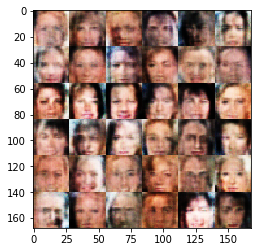

Epoch 810/1... Discriminator Loss: 1.2936... Generator Loss: 0.7016
Epoch 820/1... Discriminator Loss: 1.1725... Generator Loss: 0.7767
Epoch 830/1... Discriminator Loss: 1.2417... Generator Loss: 0.6657
Epoch 840/1... Discriminator Loss: 1.1525... Generator Loss: 0.9708
Epoch 850/1... Discriminator Loss: 1.2399... Generator Loss: 0.7198
Epoch 860/1... Discriminator Loss: 1.4056... Generator Loss: 0.8854
Epoch 870/1... Discriminator Loss: 1.2078... Generator Loss: 0.8200
Epoch 880/1... Discriminator Loss: 1.3335... Generator Loss: 0.6081
Epoch 890/1... Discriminator Loss: 1.3046... Generator Loss: 0.6053
Epoch 900/1... Discriminator Loss: 1.3514... Generator Loss: 0.6855


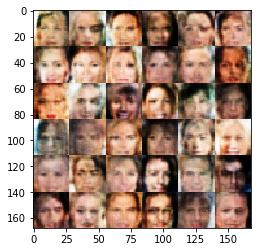

Epoch 910/1... Discriminator Loss: 1.2484... Generator Loss: 0.7628
Epoch 920/1... Discriminator Loss: 1.3026... Generator Loss: 0.8396
Epoch 930/1... Discriminator Loss: 1.1541... Generator Loss: 0.9060
Epoch 940/1... Discriminator Loss: 1.4015... Generator Loss: 0.7739
Epoch 950/1... Discriminator Loss: 1.2833... Generator Loss: 0.9554
Epoch 960/1... Discriminator Loss: 1.2806... Generator Loss: 0.7335
Epoch 970/1... Discriminator Loss: 1.2777... Generator Loss: 0.9196
Epoch 980/1... Discriminator Loss: 1.3011... Generator Loss: 0.8103
Epoch 990/1... Discriminator Loss: 1.3832... Generator Loss: 0.8320
Epoch 1000/1... Discriminator Loss: 1.2162... Generator Loss: 0.7211


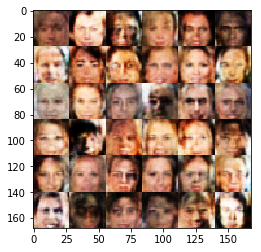

Epoch 1010/1... Discriminator Loss: 1.2506... Generator Loss: 0.7493
Epoch 1020/1... Discriminator Loss: 1.3337... Generator Loss: 0.6101
Epoch 1030/1... Discriminator Loss: 1.2729... Generator Loss: 0.6798
Epoch 1040/1... Discriminator Loss: 1.3124... Generator Loss: 0.6317
Epoch 1050/1... Discriminator Loss: 1.1468... Generator Loss: 0.8556
Epoch 1060/1... Discriminator Loss: 1.2379... Generator Loss: 0.7400
Epoch 1070/1... Discriminator Loss: 1.1968... Generator Loss: 0.9613
Epoch 1080/1... Discriminator Loss: 1.2032... Generator Loss: 0.9312
Epoch 1090/1... Discriminator Loss: 1.2403... Generator Loss: 0.7508
Epoch 1100/1... Discriminator Loss: 1.1884... Generator Loss: 0.8232


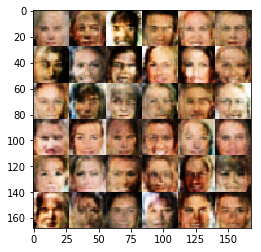

Epoch 1110/1... Discriminator Loss: 1.1860... Generator Loss: 0.8994
Epoch 1120/1... Discriminator Loss: 1.2261... Generator Loss: 0.8655
Epoch 1130/1... Discriminator Loss: 1.2255... Generator Loss: 0.8867
Epoch 1140/1... Discriminator Loss: 1.2354... Generator Loss: 0.7743
Epoch 1150/1... Discriminator Loss: 1.1858... Generator Loss: 0.8154
Epoch 1160/1... Discriminator Loss: 1.2157... Generator Loss: 0.8299
Epoch 1170/1... Discriminator Loss: 1.1833... Generator Loss: 0.9283
Epoch 1180/1... Discriminator Loss: 1.1200... Generator Loss: 1.0304
Epoch 1190/1... Discriminator Loss: 1.2743... Generator Loss: 1.1525
Epoch 1200/1... Discriminator Loss: 1.1899... Generator Loss: 0.9982


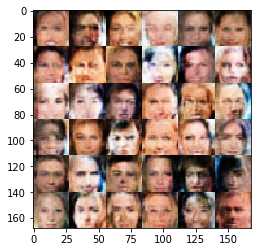

Epoch 1210/1... Discriminator Loss: 1.1523... Generator Loss: 0.6889
Epoch 1220/1... Discriminator Loss: 1.2335... Generator Loss: 1.1142
Epoch 1230/1... Discriminator Loss: 1.1990... Generator Loss: 1.0811
Epoch 1240/1... Discriminator Loss: 1.2273... Generator Loss: 0.6403
Epoch 1250/1... Discriminator Loss: 1.1869... Generator Loss: 0.7658
Epoch 1260/1... Discriminator Loss: 1.1752... Generator Loss: 0.7735
Epoch 1270/1... Discriminator Loss: 1.1552... Generator Loss: 0.8008
Epoch 1280/1... Discriminator Loss: 1.2739... Generator Loss: 0.5758
Epoch 1290/1... Discriminator Loss: 1.2517... Generator Loss: 1.1040
Epoch 1300/1... Discriminator Loss: 1.1705... Generator Loss: 1.1647


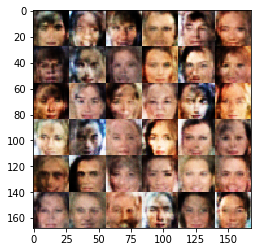

Epoch 1310/1... Discriminator Loss: 1.1701... Generator Loss: 0.8284
Epoch 1320/1... Discriminator Loss: 1.3260... Generator Loss: 0.5958
Epoch 1330/1... Discriminator Loss: 1.1635... Generator Loss: 0.9969
Epoch 1340/1... Discriminator Loss: 1.2270... Generator Loss: 0.7863
Epoch 1350/1... Discriminator Loss: 1.2316... Generator Loss: 0.8768
Epoch 1360/1... Discriminator Loss: 1.3009... Generator Loss: 0.6351
Epoch 1370/1... Discriminator Loss: 1.1500... Generator Loss: 1.0591
Epoch 1380/1... Discriminator Loss: 1.1539... Generator Loss: 0.8432
Epoch 1390/1... Discriminator Loss: 1.2355... Generator Loss: 0.9501
Epoch 1400/1... Discriminator Loss: 1.1929... Generator Loss: 0.8198


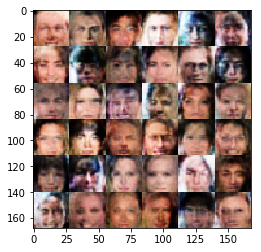

Epoch 1410/1... Discriminator Loss: 1.2323... Generator Loss: 1.1858
Epoch 1420/1... Discriminator Loss: 1.2482... Generator Loss: 0.7878
Epoch 1430/1... Discriminator Loss: 1.2540... Generator Loss: 1.2128
Epoch 1440/1... Discriminator Loss: 1.1924... Generator Loss: 0.8259
Epoch 1450/1... Discriminator Loss: 1.2208... Generator Loss: 0.7518
Epoch 1460/1... Discriminator Loss: 1.2529... Generator Loss: 0.6671
Epoch 1470/1... Discriminator Loss: 1.1840... Generator Loss: 0.7705
Epoch 1480/1... Discriminator Loss: 1.2331... Generator Loss: 1.1422
Epoch 1490/1... Discriminator Loss: 1.2665... Generator Loss: 0.6534
Epoch 1500/1... Discriminator Loss: 1.1503... Generator Loss: 0.9845


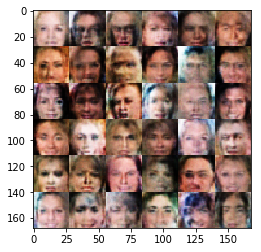

Epoch 1510/1... Discriminator Loss: 1.2104... Generator Loss: 0.9825
Epoch 1520/1... Discriminator Loss: 1.2501... Generator Loss: 0.7742
Epoch 1530/1... Discriminator Loss: 1.1297... Generator Loss: 0.8333
Epoch 1540/1... Discriminator Loss: 1.3883... Generator Loss: 1.4604
Epoch 1550/1... Discriminator Loss: 1.3483... Generator Loss: 1.1078
Epoch 1560/1... Discriminator Loss: 1.1191... Generator Loss: 1.0872
Epoch 1570/1... Discriminator Loss: 1.1486... Generator Loss: 1.0456
Epoch 1580/1... Discriminator Loss: 1.1183... Generator Loss: 0.8697


In [88]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.